# Approximating Lévy Stable log density

In [1]:
import math
import numpy as np
from scipy.stats import levy_stable
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.linewidth'] = 0.1
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levy_stable.html
levy_stable.parameterization = "S0"

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def logit(x):
    return np.log(x) - np.log1p(-x)

def _():
    x = np.linspace(-10, 10, 100)
    assert np.allclose(x, logit(sigmoid(x)))
_()

In [3]:
a_grid = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
b_grid = [0.0, 0.2, 0.5, 0.8, 0.9, 1.0]
x_grid = [-10.0, -1.0, -0.1, 0.0, 0.1, 1.0, 10.0]

Let's build up some intuition by visualizing the density on a transformed real line `x = atanh(reals)`.

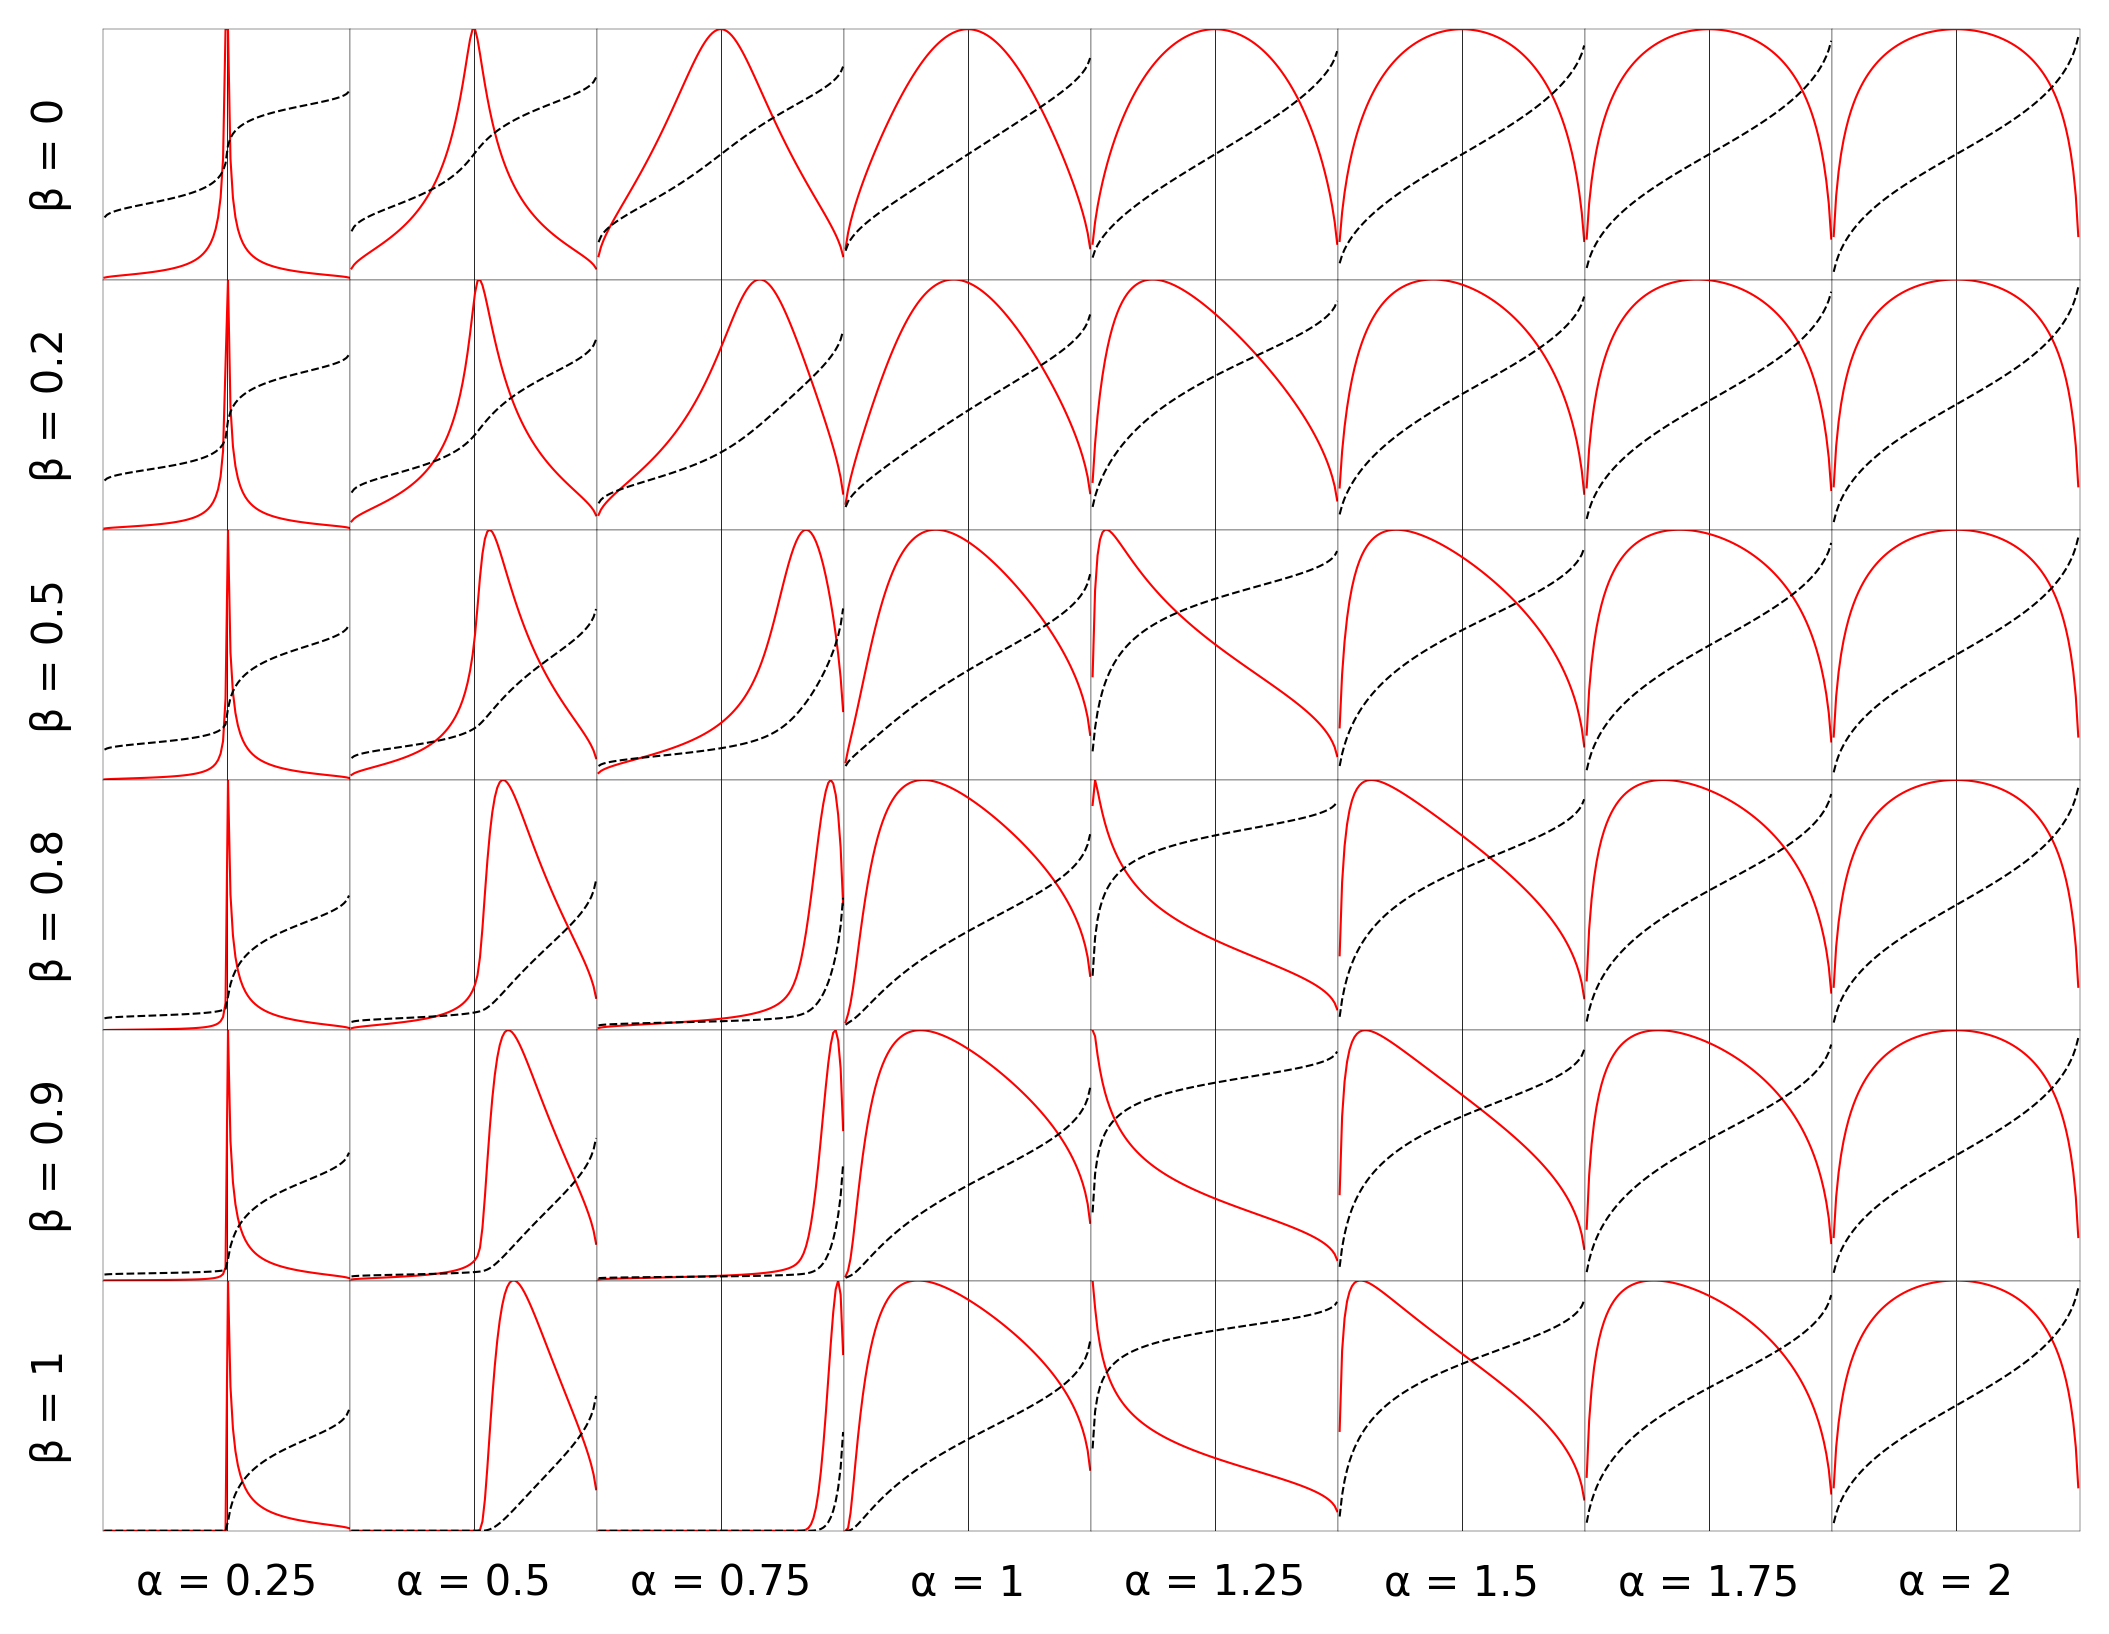

In [4]:
def plot_density(n=100):
    u = np.linspace(1/n - 1, 1 - 1/n, n)
    x = np.arctanh(u)
    fig, axes = plt.subplots(
        len(b_grid), len(a_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(a_grid), 0.5 + len(b_grid)), dpi=300)
    for i, b in enumerate(b_grid):
        for j, a in enumerate(a_grid):
            ax = axes[i][j]
            ax.axvline(0, lw=0.2, color="k")
            p = levy_stable(a, b).pdf(x)
            p /= p.max()
            ax.plot(u, p, "r-", lw=0.5)
            c = levy_stable(a, b).cdf(x)
            ax.plot(u, c, "k--", lw=0.5)
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(b_grid) - 1:
                ax.set_xlabel(f"α = {a:0.3g}")
            if j == 0:
                ax.set_ylabel(f"β = {b:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)
plot_density()

Now let's try to make the cdf easier to approximate by transforming both the x and y axes while preserving the asymptotic power law behavior of tails, namely that ([Nolan (2020)](https://edspace.american.edu/jpnolan/stable/) ss. 1.5 pp. 13 thm. 1.2) if $X\sim S(\alpha,\beta,\gamma,\delta;0)$ then
$$
P(X > x) \sim \gamma^\alpha c_\alpha (1+\beta) x^{-\alpha}
$$
where
$$
c_\alpha = \sin\left(\frac {\pi\alpha} 2\right)\Gamma(\alpha)/\pi
$$

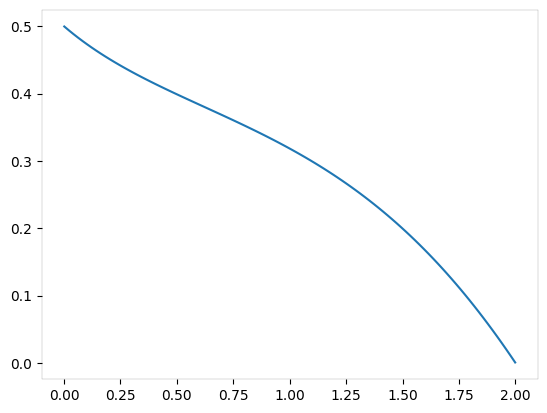

In [5]:
def plot_ca(eps=1e-3):
    a = np.linspace(0 + eps, 2 - eps, 100)
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    plt.plot(a, ca)
plot_ca()

We want to achieve the two asymptotes, in value (cdf) and in formal first derivative (pdf):
\begin{align*}
\text{Near }u=+1\!:&\quad
  u \approx 1 - 2 c_\alpha(1+\beta)x(u)^{-\alpha}
  &&\quad\implies\quad
  x(u) \approx \left(\frac{2c_\alpha(1-\beta)}{1-u}\right)^{1/\alpha}
\\
\text{Near }u=-1\!:&\quad
  u \approx 2 c_\alpha(1-\beta)(-x(u))^{-\alpha} - 1
  &&\quad\implies\quad
  x(u) \approx -\left(\frac{2c_\alpha(1+\beta)}{1+u}\right)^{1/\alpha}
\end{align*}
Thus consider a naively interpolated coordinate system with $u\in(-1,1)$
$$
x(u) = u\left(\frac
{2c_\alpha(1+\beta u)}
{1-u^2}
\right)^{1/\alpha}
$$

In [6]:
def plot_transformed_cdf(x_of_u, n=100, eps=1e-3):
    u = np.linspace(eps - 1, 1 - eps, n)  # in (-1,1)
    fig, axes = plt.subplots(
        len(b_grid), len(a_grid), sharex=True, sharey=True,
        figsize=(0.5 + len(a_grid), 0.5 + len(b_grid)), dpi=300)
    for i, b in enumerate(b_grid):
        for j, a in enumerate(a_grid):
            x = x_of_u(u, a, b)
            v = levy_stable(a, b).cdf(x)
            ax = axes[i][j]
            ax.plot(u, v, "r-", lw=0.5)
            ax.plot([-1,1], [0,1], 'k--', lw=0.5, zorder=-1)
            ax.axvline(0, lw=0.2, color="k")
            ax.set_xlim(-1, 1)
            ax.set_ylim(0, 1)
            ax.set_xticks(())
            ax.set_yticks(())
            if i == len(b_grid) - 1:
                ax.set_xlabel(f"α = {a:0.3g}")
            if j == 0:
                ax.set_ylabel(f"β = {b:0.3g}")
    plt.subplots_adjust(hspace=0, wspace=0)

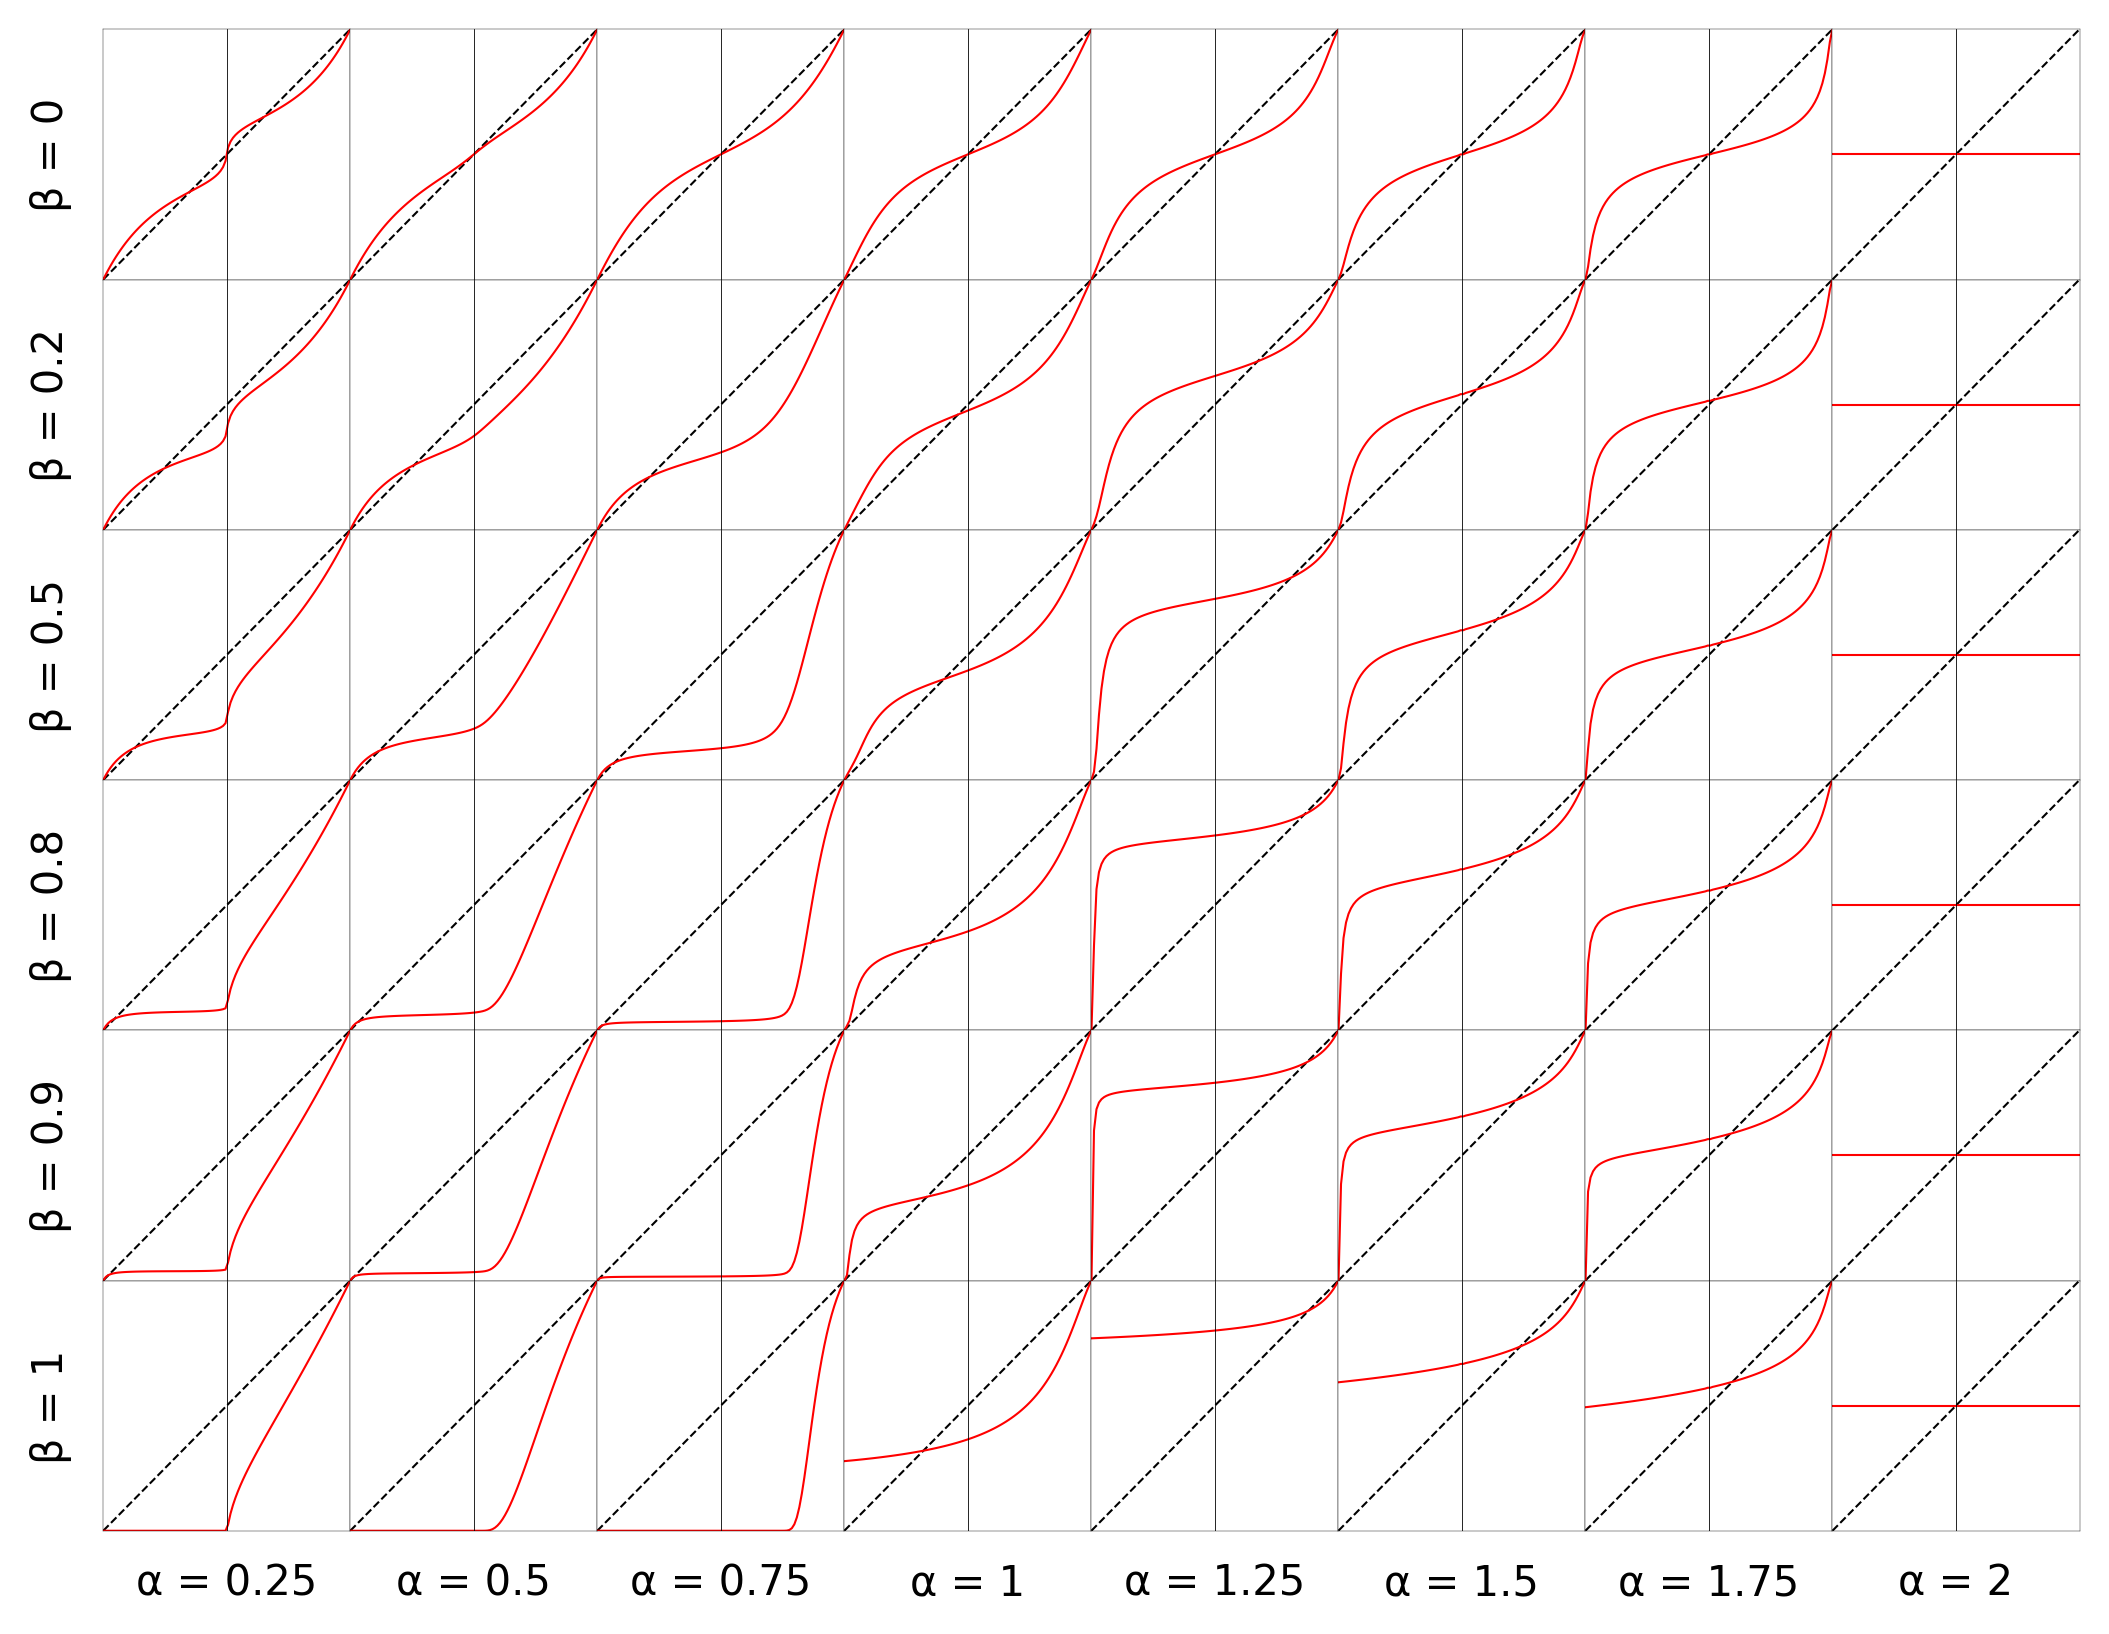

In [7]:
@plot_transformed_cdf
def x_of_u(u, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    x = u * (2 * ca * (1 + b * u) / (1 - u**2)) ** (1/a)
    return x

It looks like the interpolation coefficients are breaking the derivative asymptotes, so the pdf will be wrong. Let's double check with piecewise interpolation.

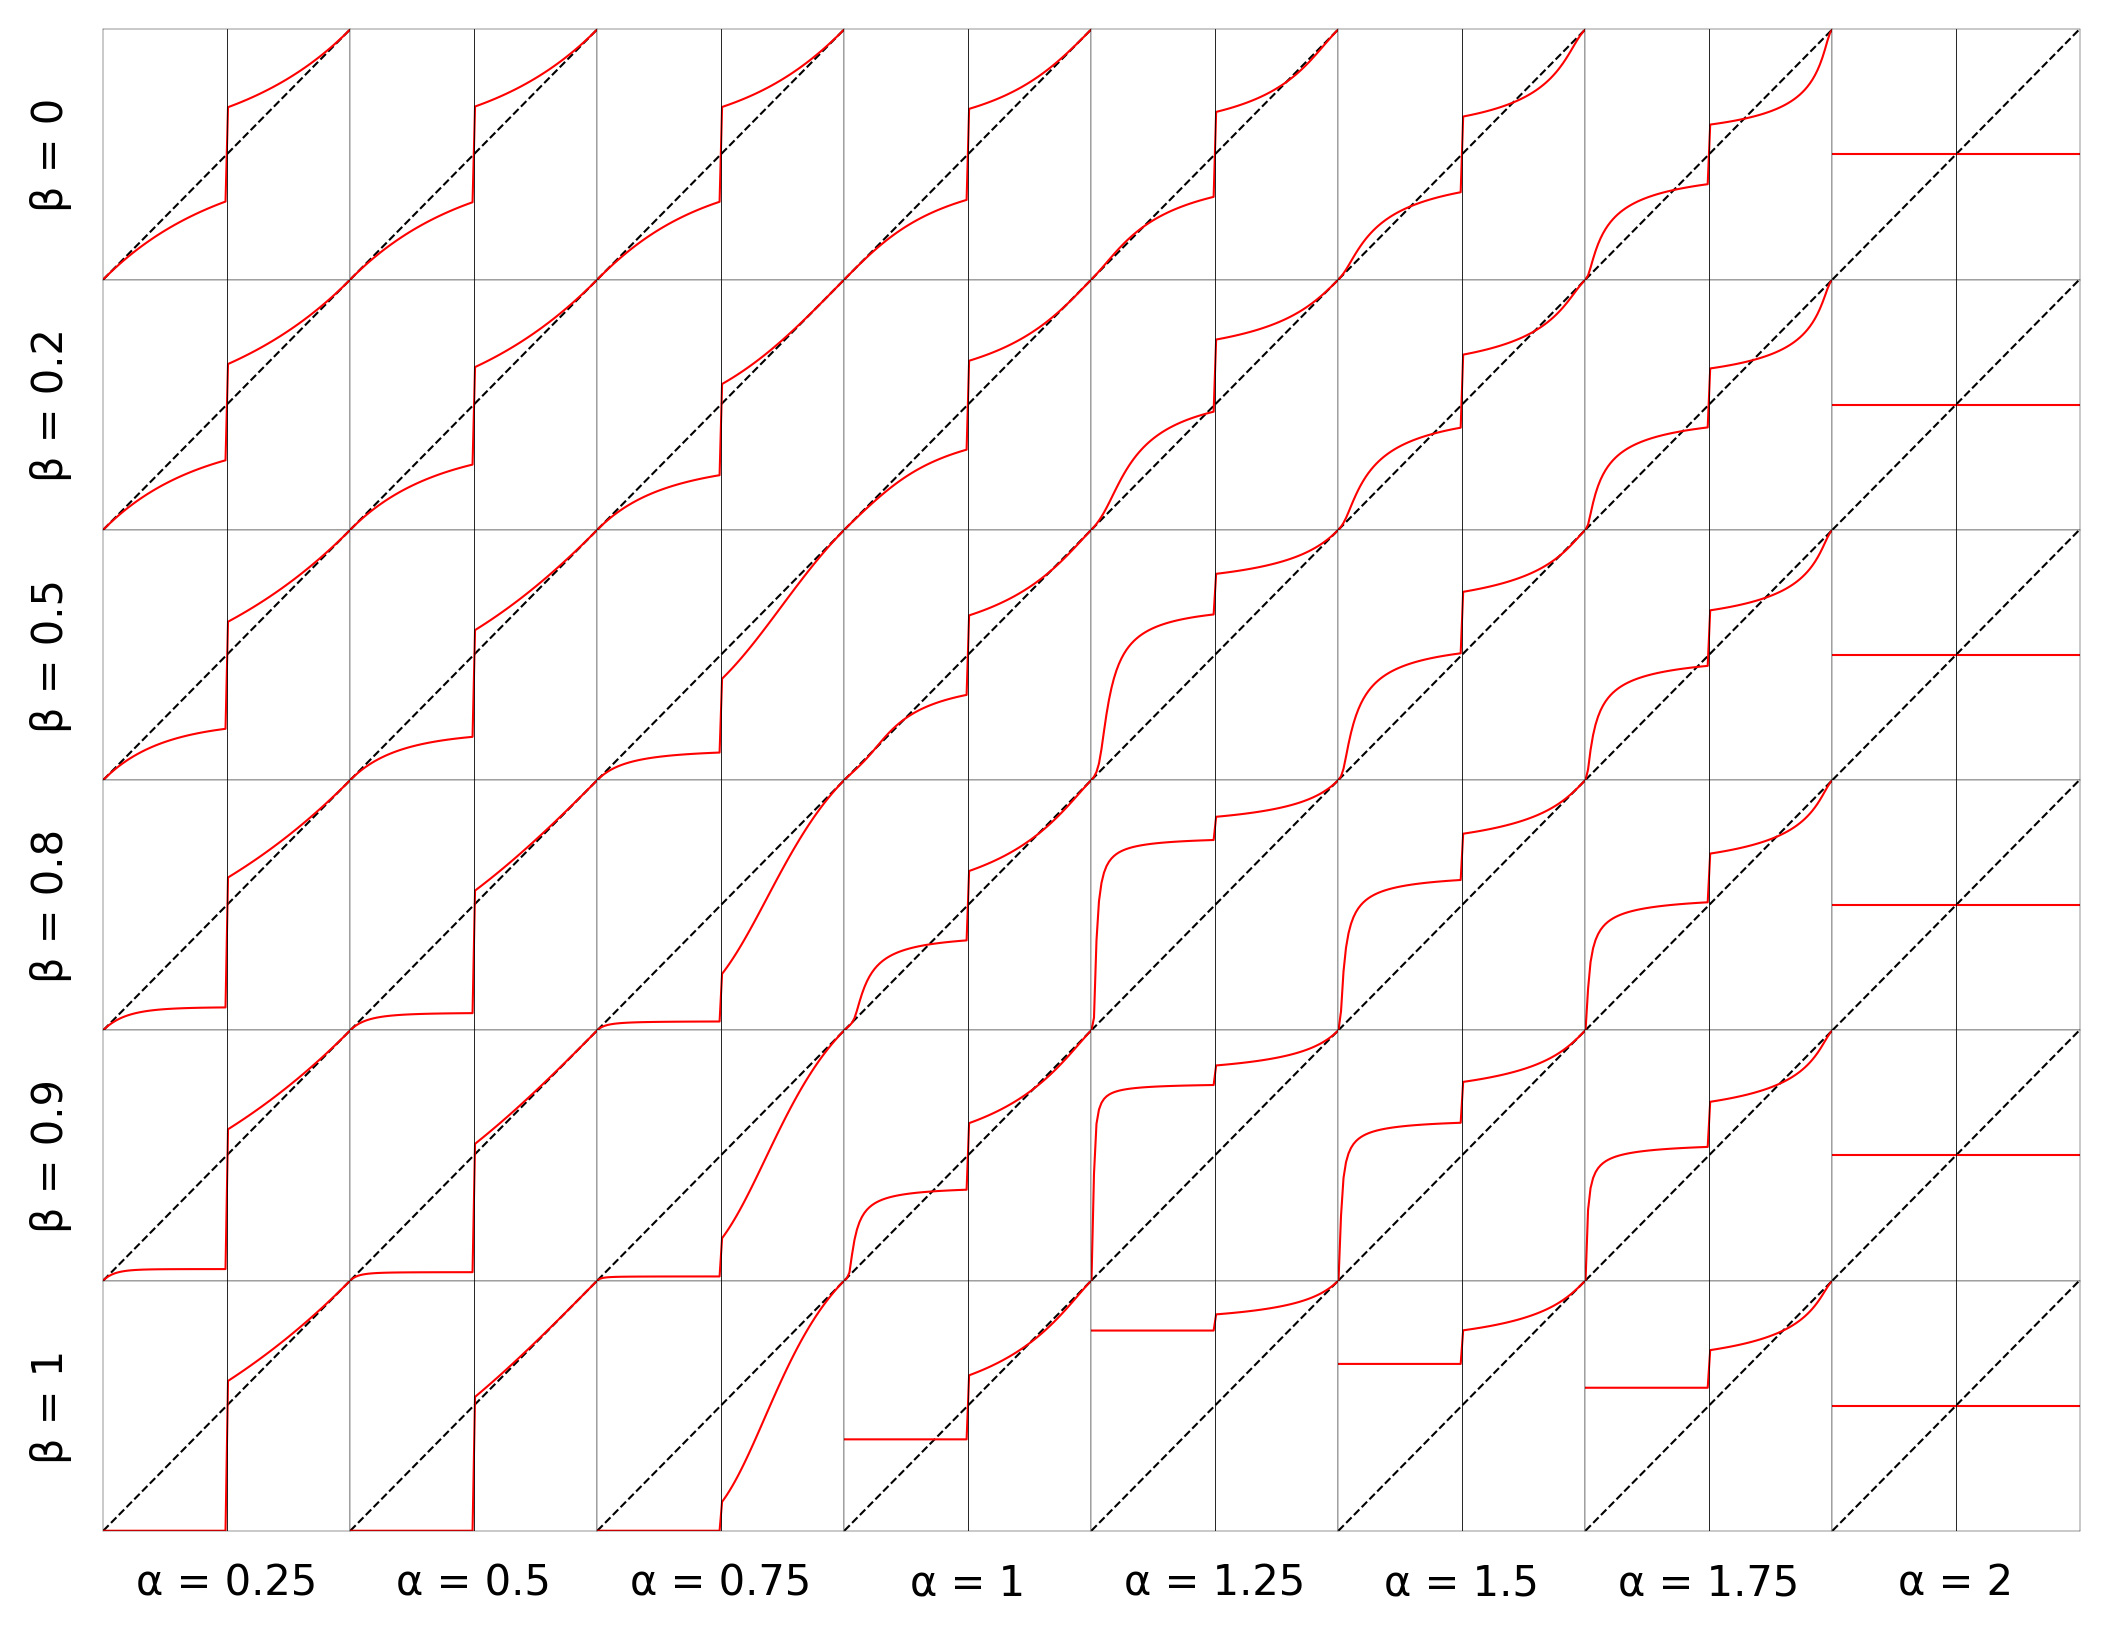

In [8]:
@plot_transformed_cdf
def x_of_u(u, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    uu = np.sign(u)
    x = uu * (2 * ca * (1 + b * uu) / (1-u*uu)) ** (1/a)
    return x

The asymptotes now seem to work, but they only hold very far from zero when $\alpha\ge 1.8$ or $|\beta|\ge 0.8$.

Let's try a gentler cubic interpolation.

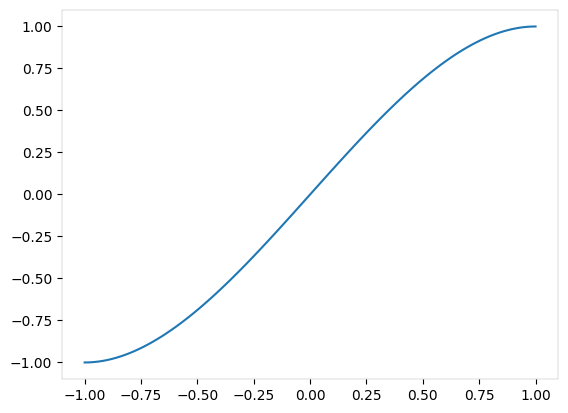

In [9]:
def plot_s():
    u = np.linspace(-1, 1, 100)
    v = u * (3 - u**2) / 2
    plt.plot(u, v)
plot_s()

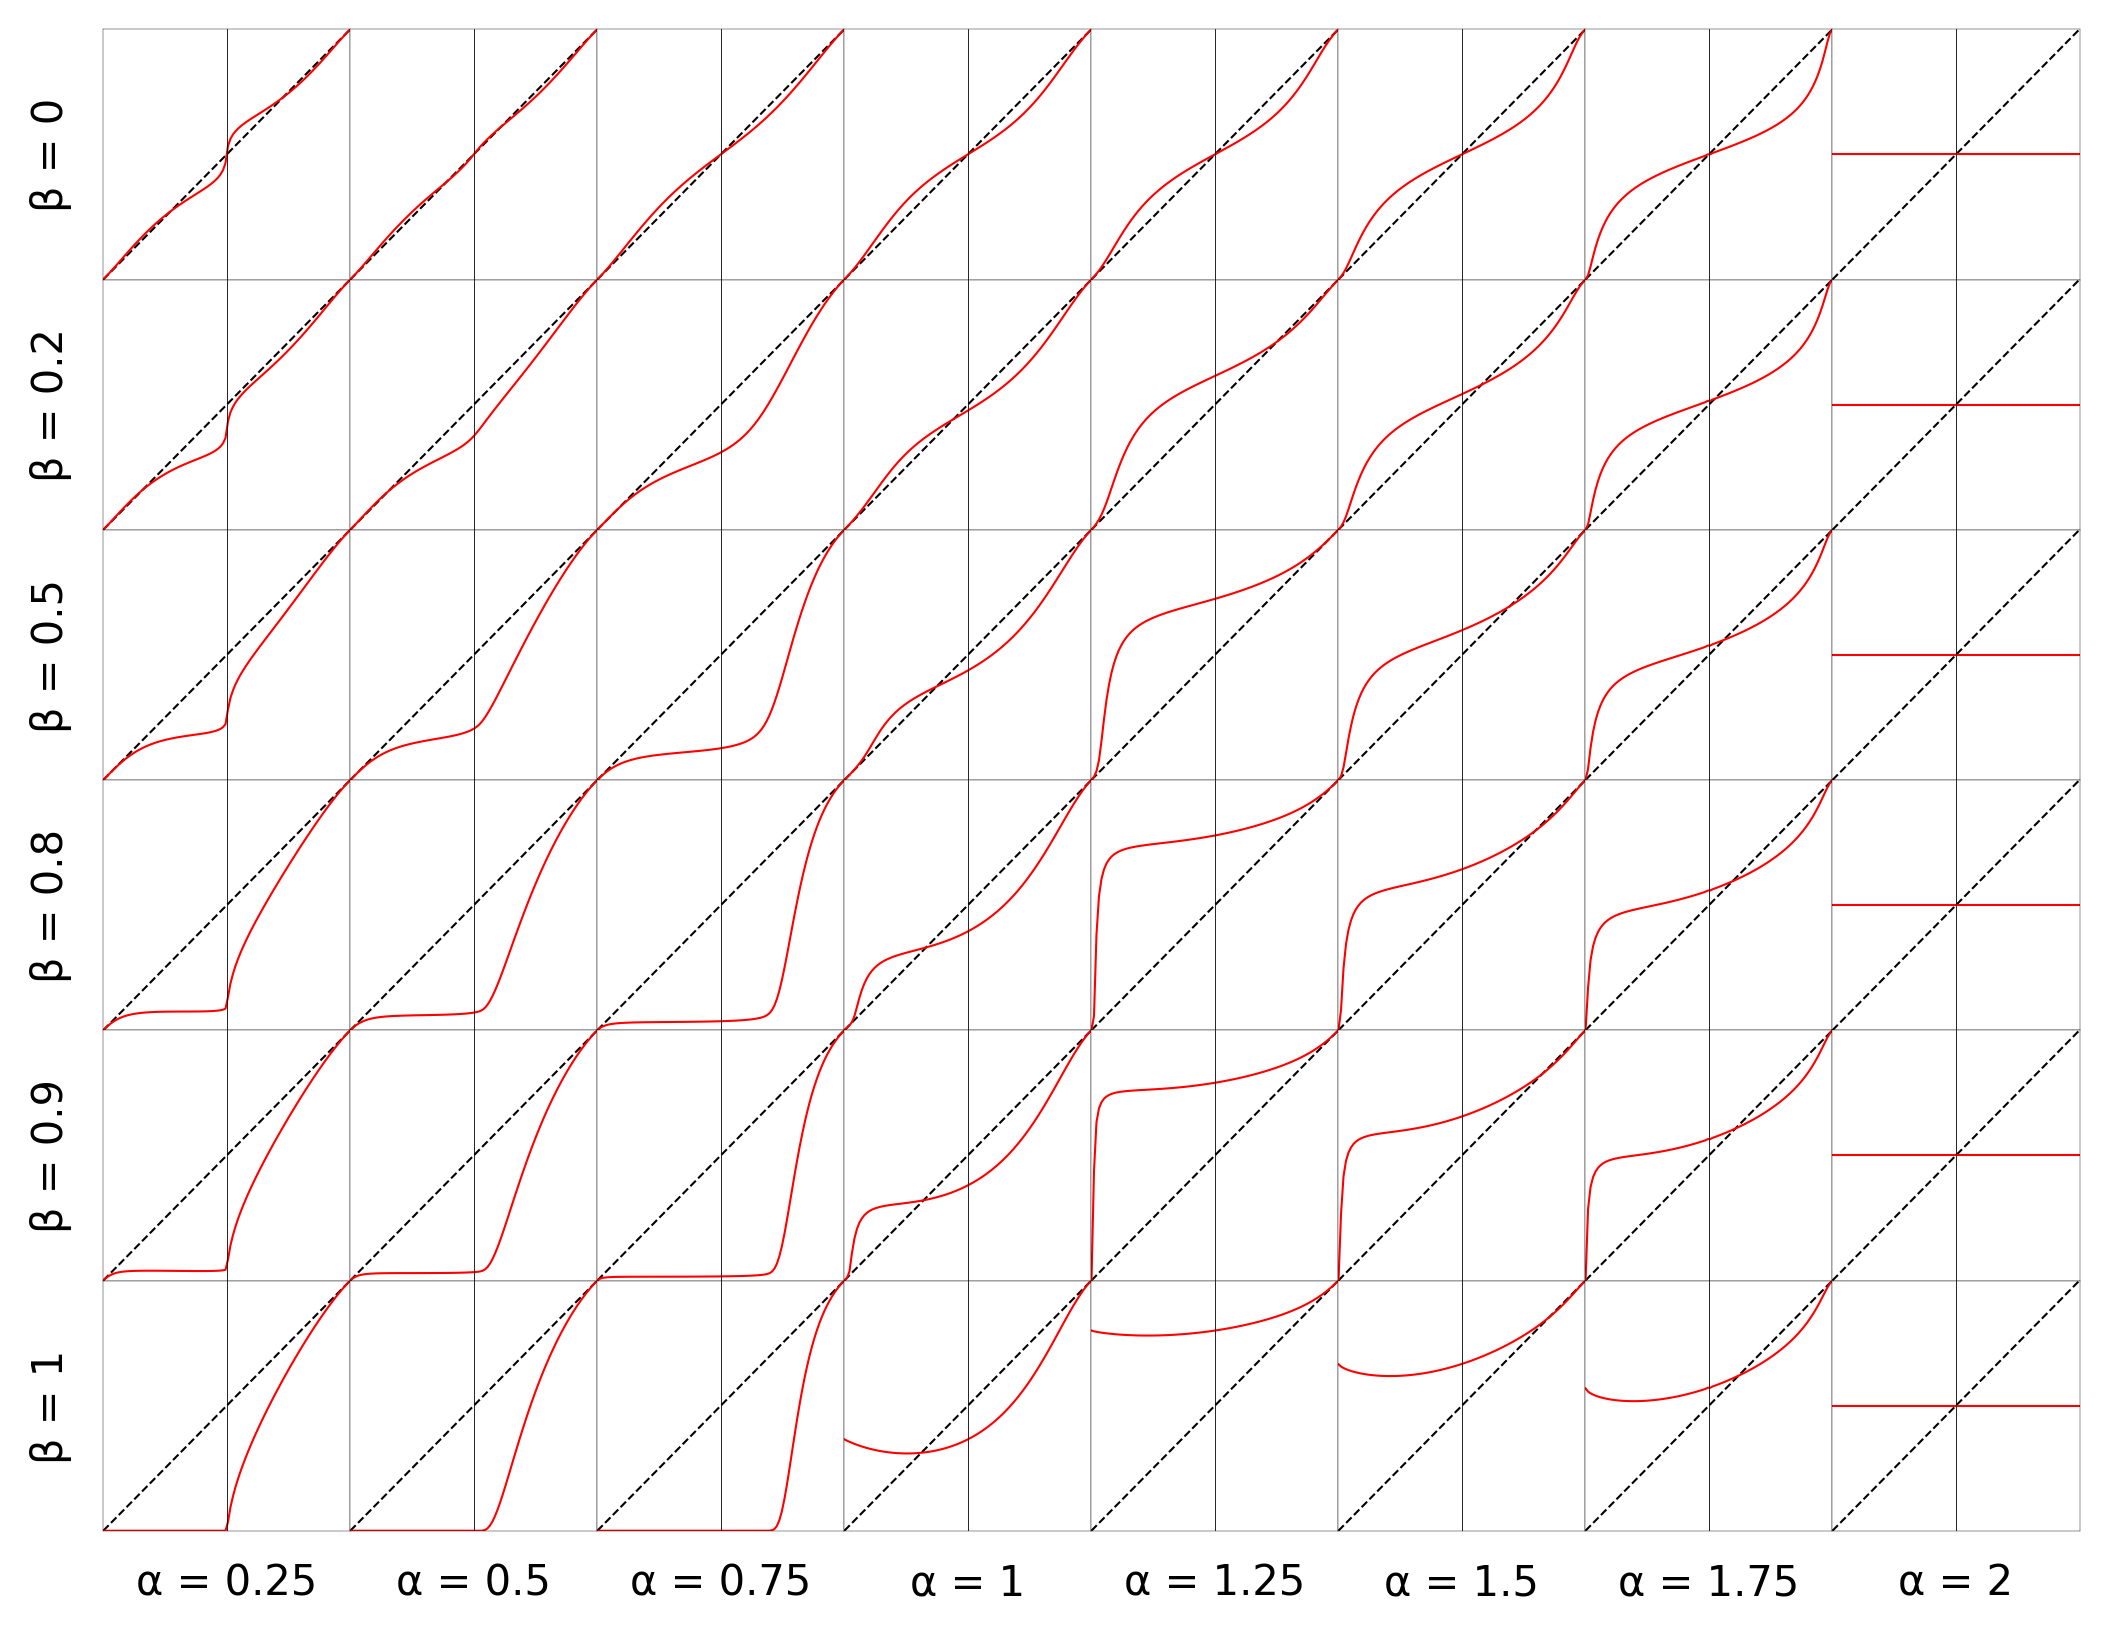

In [10]:
@plot_transformed_cdf
def x_of_u(u, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    w = u * (3 - u**2) / 2
    x = w * (2 * ca * (1 + b * w) / (1 - u * w)) ** (1/a)
    return x

It looks like the derivatives are now good for small $\alpha$ but break for large $\alpha$. Maybe the $2/c_\alpha$ factor is skewing the large-$\alpha$ curves. What if we drop it, replacing $2 c_\alpha \to 1$?

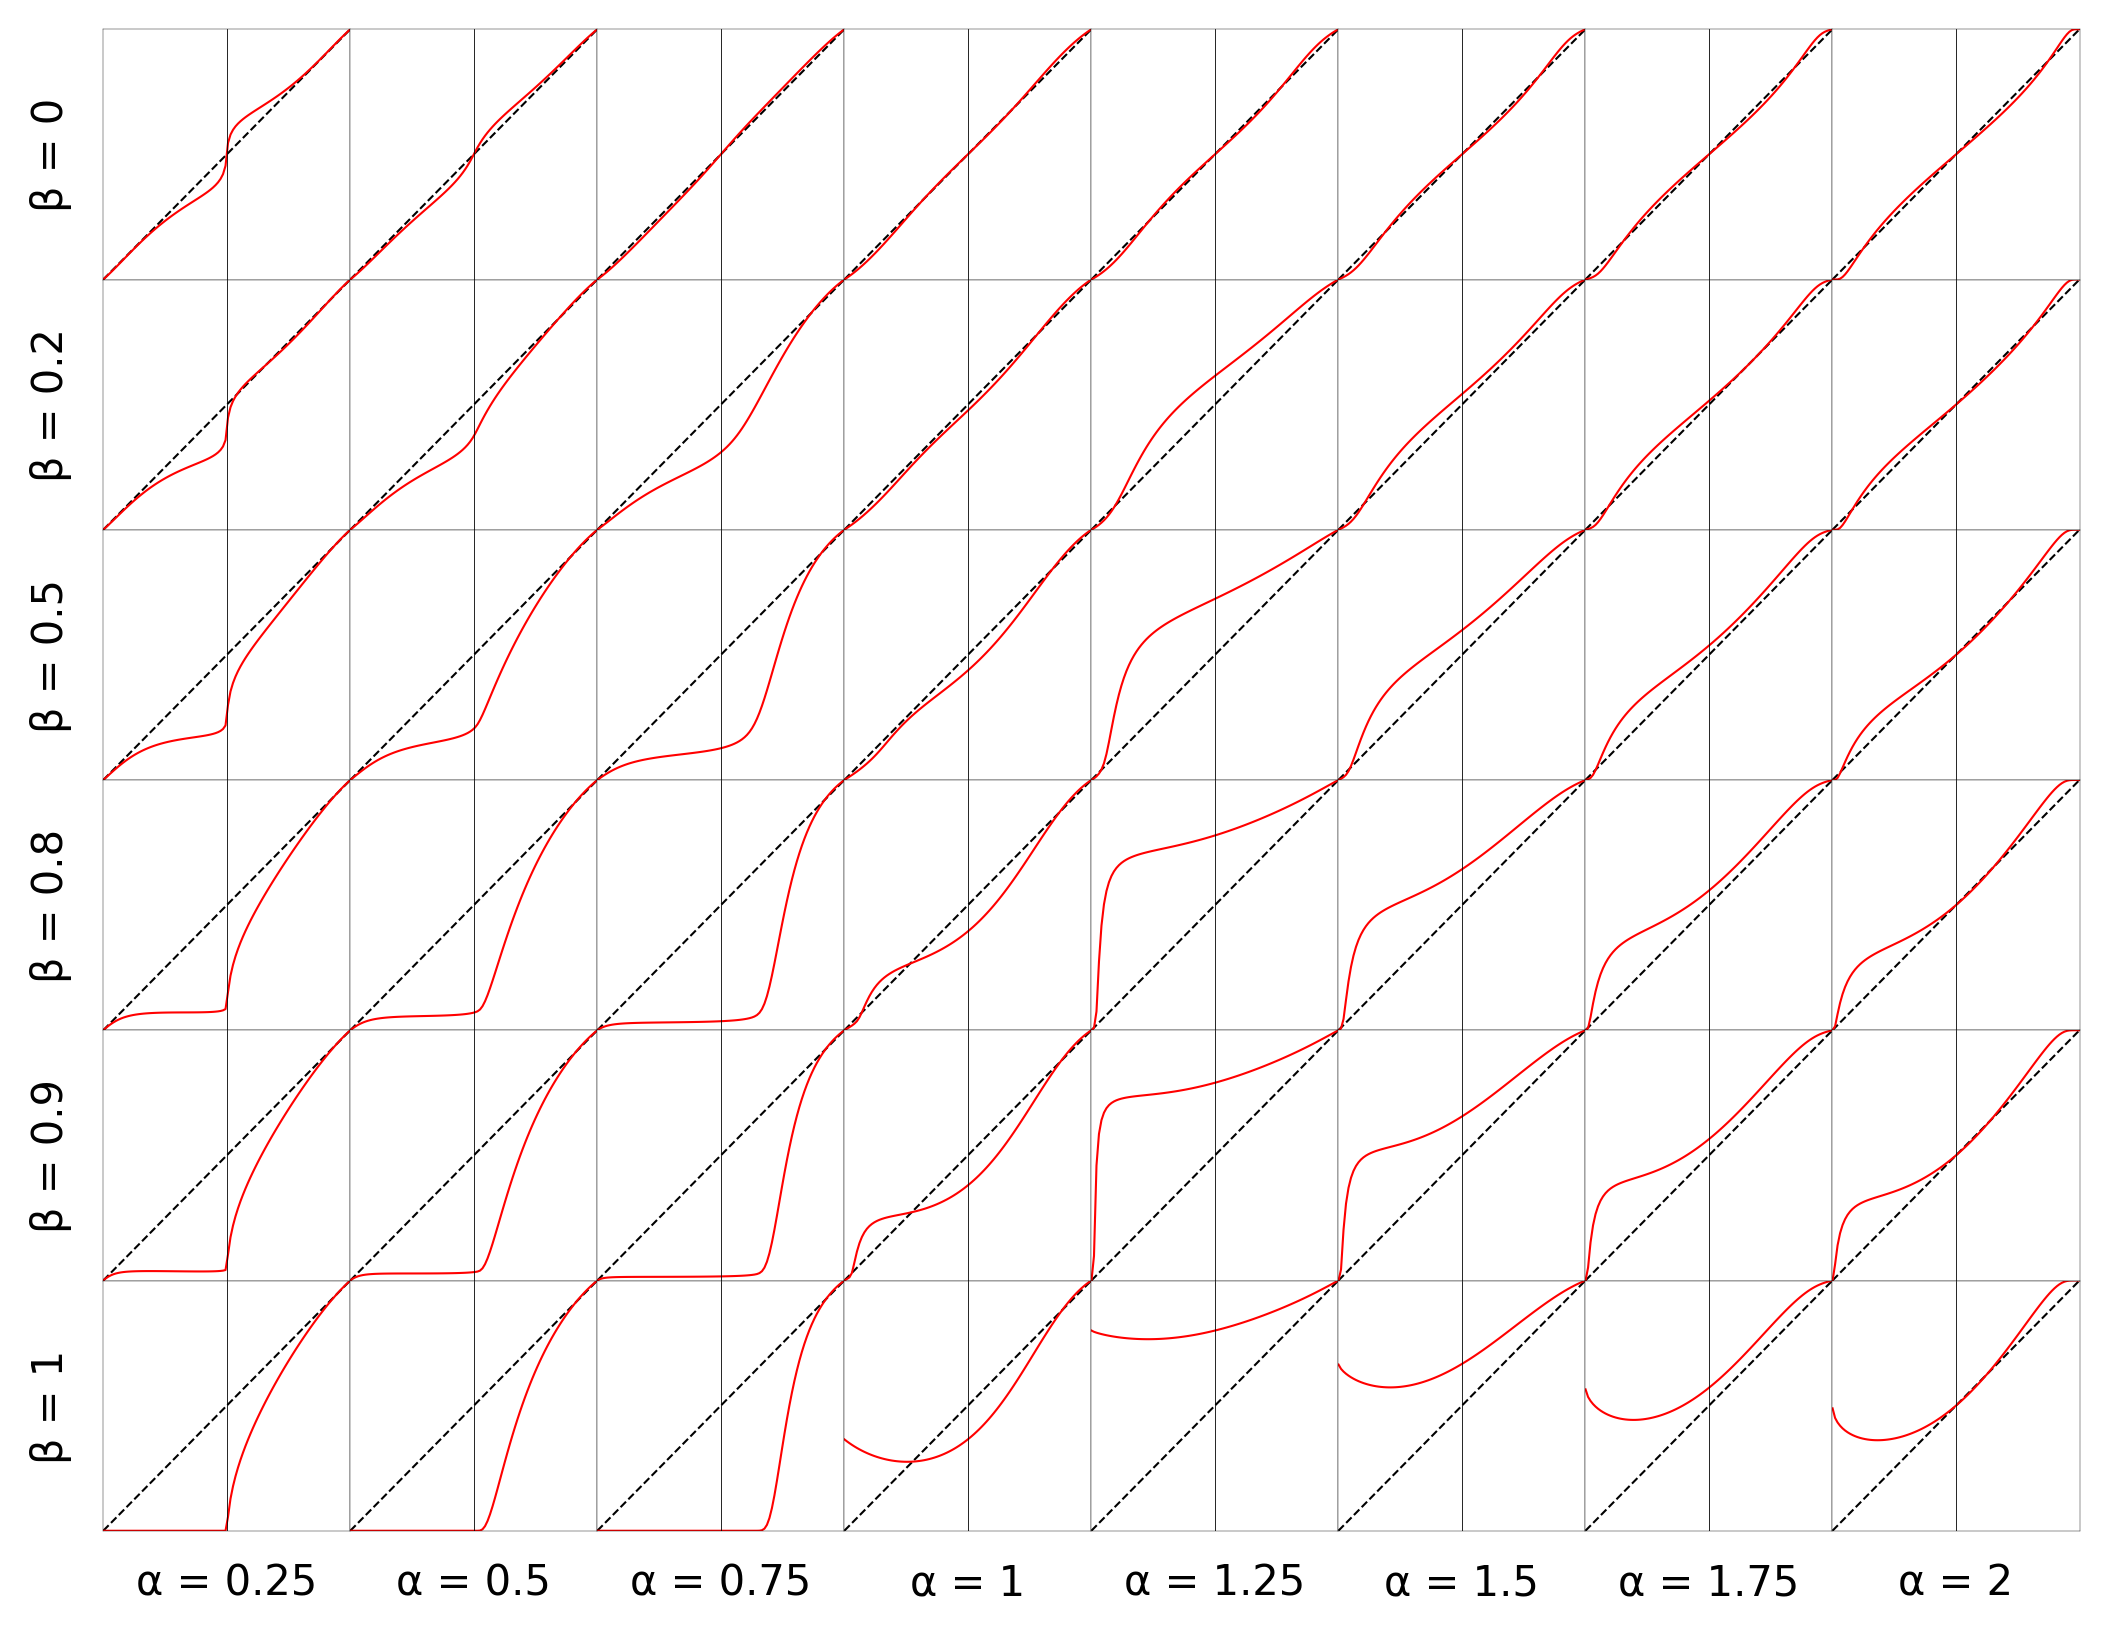

In [11]:
@plot_transformed_cdf
def x_of_u(u, a, b):
    w = (u + 1)**2 * (1 - u / 2) - 1
    x = w * ((1 + b * w) / (1 - u * w)) ** (1/a)
    return x

This appears to qualitatively match the important regime of $\beta\approx 0$, $\alpha\approx 2$.  Can we replace some terms with the normal cdf or erf to improve the fit in this regime?

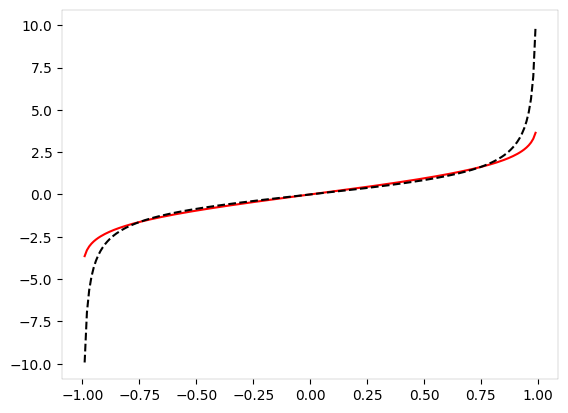

In [12]:
def plot_erf(n=200, eps=1e-2):
    u = np.linspace(eps - 1, 1 - eps, n)
    plt.plot(u, 2 * scipy.special.erfinv(u), "r-")
    w = (u + 1)**2 * (1 - u / 2) - 1
    v = w * (1 / (1 - u * w)) ** (1/2)
    plt.plot(u, v, "k--")
plot_erf()

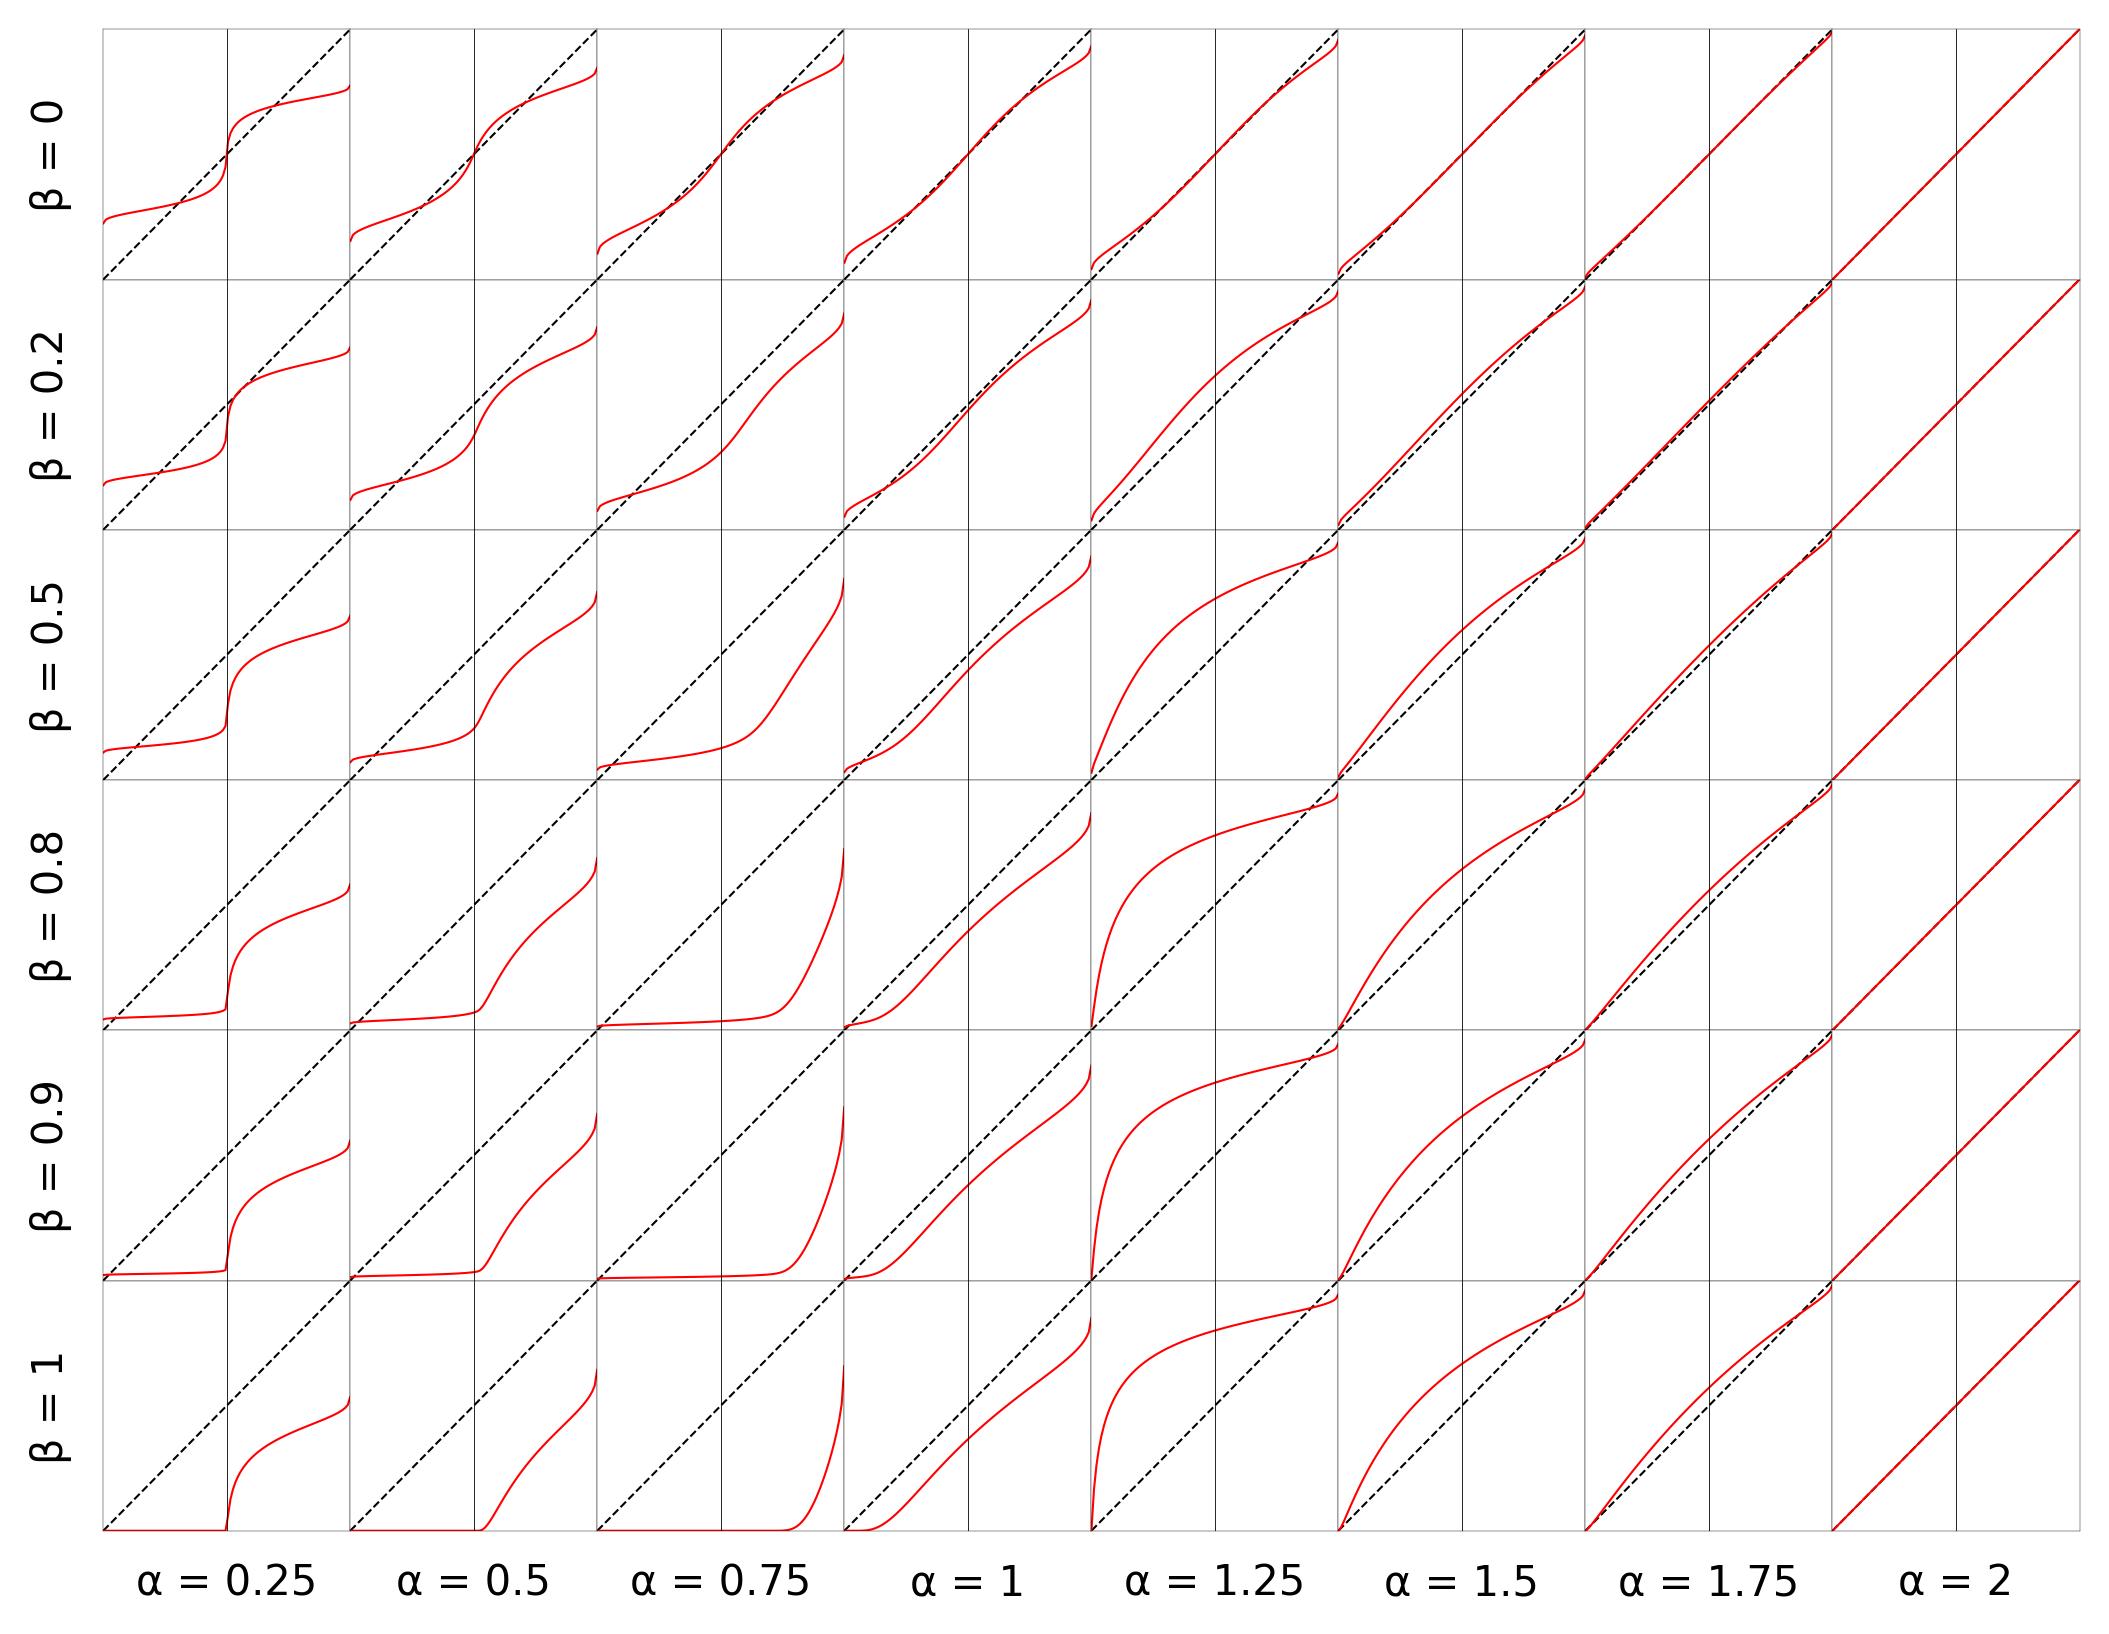

In [13]:
@plot_transformed_cdf
def x_of_u(u, a, b):
    x = 2 * scipy.special.erfinv(u)
    return x

This perfectly matches the Gaussian case $\alpha=2$, but misses the cases of smaller $\alpha$.

Consider three special cases:
\begin{align*}
\text{When }u\approx+1\!:&\quad
  x(u) \approx \left(\frac{2c_\alpha(1-\beta)}{1-u}\right)^{1/\alpha}
\\
\text{When }u\approx-1\!:&\quad
  x(u) \approx -\left(\frac{2c_\alpha(1+\beta)}{1+u}\right)^{1/\alpha}
\\
\text{When }\alpha\approx 2\!:&\quad
  x(u) \approx 2 \operatorname{erfinv(u)}
\end{align*}
Let's try another interpolation

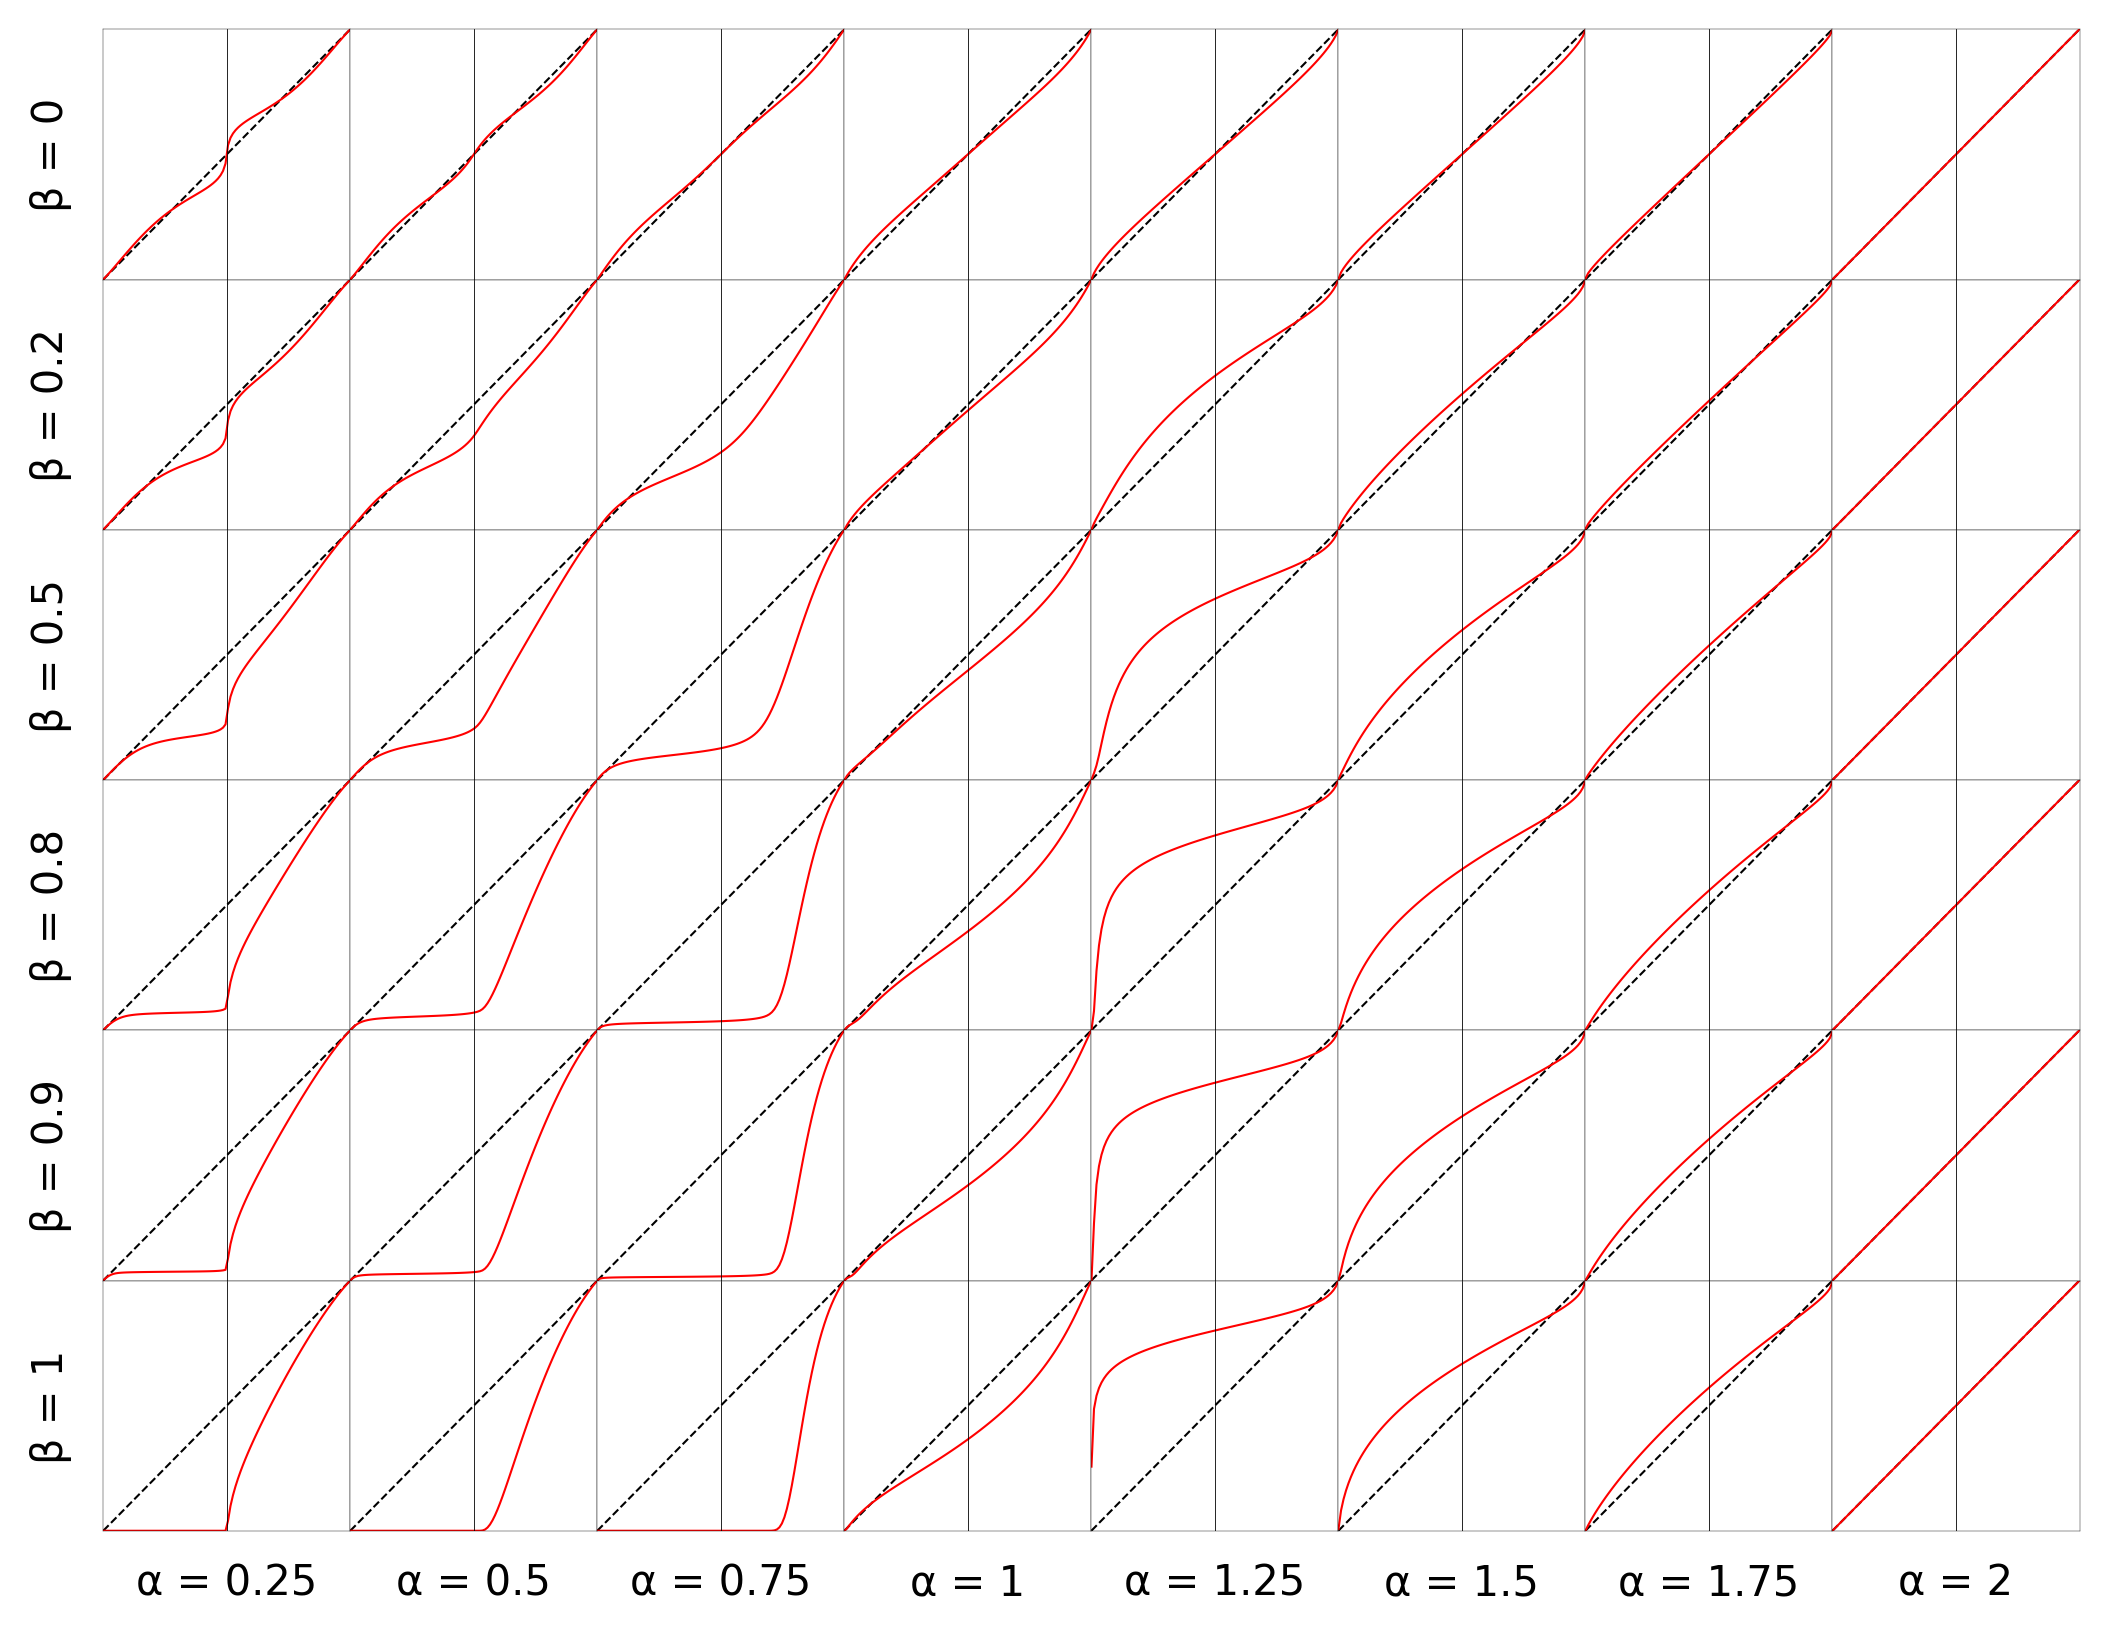

In [14]:
@plot_transformed_cdf
def x_of_u(u, a, b):
    ca = np.sin(np.pi * a / 2) * scipy.special.gamma(a) / np.pi
    w = u * (3 - u**2) / 2
    x_asymp = w * (2 * ca * (1 + b * w) / (1 - u * w)) ** (1/a)
    x_gauss = 2 * scipy.special.erfinv(u)
    g = a/2
    x = g * x_gauss + (1-g) * x_asymp
    return x